In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import copy
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output


pd.options.display.float_format = '{:20,.15f}'.format
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

current_month = '01'
next_month = '12'

start_time=f'2023-{current_month}-01 00:00:00'
stop_time=f'2023-{next_month}-01 00:00:00'

#start_time=f'2023-01-01 00:00:00'
#stop_time=f'2024-01-01 00:00:00'

tracker_initial = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db', already_calculated=True)
tracker = copy.deepcopy(tracker_initial) # make a new instance of the tracker
print(len(tracker.flights), len(tracker.flights_distinct))
tracker.flights_distinct

917944 5575


,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,3692,CLX17K,2023-01-01,2023.01.01-040336.db,2023-01-01 01:03:10.900000,2023-01-01 01:10:58.200000,136.699999999999989,8.600000000000000,18.000000000000000
1,3693,AFR271,2023-01-01,2023.01.01-040336.db,2023-01-01 01:08:27.400000,2023-01-01 01:25:17.300000,12.000000000000000,10.199999999999999,43.000000000000000
2,3694,BOX488,2023-01-01,2023.01.01-040336.db,2023-01-01 01:16:14.700000,2023-01-01 01:32:29.400000,82.299999999999997,8.000000000000000,29.000000000000000
3,3695,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 01:18:40.400000,2023-01-01 01:26:22.700000,98.000000000000000,8.600000000000000,54.000000000000000
4,3696,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 07:47:48.900000,2023-01-01 15:38:06.100000,60.100000000000001,8.300000000000001,39.000000000000000
...,...,...,...,...,...,...,...,...,...
5570,4811,N/A,2023-11-30,2023.11.30-171511.db,2023-11-30 03:35:48.800000,2023-11-30 08:55:27.100000,115.000000000000000,10.199999999999999,65.000000000000000
5571,4812,DAL142,2023-11-30,2023.11.30-171511.db,2023-11-30 04:30:49.900000,2023-11-30 04:43:23.500000,112.500000000000000,9.500000000000000,31.000000000000000
5572,4813,THY8JK,2023-11-30,2023.11.30-171511.db,2023-11-30 08:37:06.700000,2023-11-30 08:55:17.000000,30.899999999999999,9.500000000000000,12.000000000000000
5573,4814,FIN2,2023-11-30,2023.11.30-171511.db,2023-11-30 10:14:55.200000,2023-11-30 10:33:10.600000,55.799999999999997,11.000000000000000,8.000000000000000


In [2]:
#save the flights_distinct table with header information joined
con = sqlite3.connect('./header_files_for_time_range/header_2023')

# Write the DataFrame to the SQLite database
tables = pd.read_sql_query(f'Select name from sqlite_master where type = "table"', con)

# Close the database connection
con.close()
tables

,name
0,all_triggers_2023_03
1,all_triggers_2023_04
2,all_triggers_2023_06
3,all_triggers_2023_07
4,all_triggers_2023_08
5,all_triggers_2023_09
6,all_triggers_2023_10
7,all_triggers_2023_11
8,all_triggers_2023_05


In [4]:
'''con = sqlite3.connect('./header_files_for_time_range/header_2023')

temp_df = pd.read_sql_query(f'Select * from all_triggers_2023_04 where lt_triggers = 1', con)

con.close()
print(len(temp_df))'''

temp_df = pd.DataFrame()
con = sqlite3.connect('./header_files_for_time_range/header_2023')
for table in tables.name:
    try:
        temp = pd.read_sql_query(f'Select * From {table} where lt_triggers = 1', con)
        if(len(temp_df == 0)):
            temp_df = temp
        else:
            temp_df = pd.concat([temp_df, temp], ignore_index=True, sort=False)
    except:
        print(f'Some problem with {table}')
con.close()
temp_df

Some problem with all_triggers_2023_11


,index,station_number,run_number,event_number,trigger_time,radiant_triggers,lt_triggers,force_triggers
0,5,11,2084,7427,"1,682,928,357.386026620864868",0,1,0
1,21,11,2084,7443,"1,682,928,369.010512351989746",0,1,0
2,22,11,2084,7444,"1,682,928,369.503270387649536",0,1,0
3,26,11,2084,7448,"1,682,928,371.716548681259155",0,1,0
4,30,11,2084,7452,"1,682,928,374.912676334381104",0,1,0
...,...,...,...,...,...,...,...,...
4856104,9112751,24,1397,831,"1,685,526,800.990732908248901",0,1,0
4856105,9112752,24,1397,832,"1,685,526,801.763359308242798",0,1,0
4856106,9112753,24,1397,833,"1,685,526,802.987482786178589",0,1,0
4856107,9112754,24,1397,834,"1,685,526,803.648054599761963",0,1,0


In [5]:
# add fk_date_flightnumber
flights_distinct = tracker.flights_distinct
flights_distinct = sqldf(''' 
SELECT
    *
    ,date || '_' || flightnumber as fk_date_flightnumber
FROM flights_distinct
''')
flights = tracker.flights
flights = sqldf(''' 
SELECT
    *
    ,date(readtime) || '_' || flightnumber as fk_date_flightnumber
FROM flights
''')


flights_distinct['mintime'] = pd.to_datetime(flights_distinct.mintime).dt.tz_localize('UTC')
flights_distinct['maxtime'] = pd.to_datetime(flights_distinct.maxtime).dt.tz_localize('UTC')

flights_distinct['mintime_millis'] = flights_distinct.mintime.astype(np.int64) // 10 ** 6
flights_distinct['maxtime_millis'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 6

flights_distinct['mintime_sec'] = flights_distinct.mintime.astype(np.int64) // 10 ** 9
flights_distinct['maxtime_sec'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 9

flights_distinct['ID'] = flights_distinct.index

temp_df['trigger_time_millis'] = (temp_df['trigger_time'] * (10 ** 3)).astype(np.int64)
temp_df['trigger_time_sec'] = (temp_df['trigger_time']).astype(np.int64)

flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber,mintime_millis,maxtime_millis,mintime_sec,maxtime_sec,ID
0,3692,CLX17K,2023-01-01,2023.01.01-040336.db,2023-01-01 01:03:10.900000+00:00,2023-01-01 01:10:58.200000+00:00,136.699999999999989,8.600000000000000,18.000000000000000,2023-01-01_CLX17K,1672534990900,1672535458200,1672534990,1672535458,0
1,3693,AFR271,2023-01-01,2023.01.01-040336.db,2023-01-01 01:08:27.400000+00:00,2023-01-01 01:25:17.300000+00:00,12.000000000000000,10.199999999999999,43.000000000000000,2023-01-01_AFR271,1672535307400,1672536317300,1672535307,1672536317,1
2,3694,BOX488,2023-01-01,2023.01.01-040336.db,2023-01-01 01:16:14.700000+00:00,2023-01-01 01:32:29.400000+00:00,82.299999999999997,8.000000000000000,29.000000000000000,2023-01-01_BOX488,1672535774700,1672536749400,1672535774,1672536749,2
3,3695,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 01:18:40.400000+00:00,2023-01-01 01:26:22.700000+00:00,98.000000000000000,8.600000000000000,54.000000000000000,2023-01-01_N/A,1672535920400,1672536382700,1672535920,1672536382,3
4,3696,N/A,2023-01-01,2023.01.01-040336.db,2023-01-01 07:47:48.900000+00:00,2023-01-01 15:38:06.100000+00:00,60.100000000000001,8.300000000000001,39.000000000000000,2023-01-01_N/A,1672559268900,1672587486100,1672559268,1672587486,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5570,4811,N/A,2023-11-30,2023.11.30-171511.db,2023-11-30 03:35:48.800000+00:00,2023-11-30 08:55:27.100000+00:00,115.000000000000000,10.199999999999999,65.000000000000000,2023-11-30_N/A,1701315348800,1701334527100,1701315348,1701334527,5570
5571,4812,DAL142,2023-11-30,2023.11.30-171511.db,2023-11-30 04:30:49.900000+00:00,2023-11-30 04:43:23.500000+00:00,112.500000000000000,9.500000000000000,31.000000000000000,2023-11-30_DAL142,1701318649900,1701319403500,1701318649,1701319403,5571
5572,4813,THY8JK,2023-11-30,2023.11.30-171511.db,2023-11-30 08:37:06.700000+00:00,2023-11-30 08:55:17+00:00,30.899999999999999,9.500000000000000,12.000000000000000,2023-11-30_THY8JK,1701333426700,1701334517000,1701333426,1701334517,5572
5573,4814,FIN2,2023-11-30,2023.11.30-171511.db,2023-11-30 10:14:55.200000+00:00,2023-11-30 10:33:10.600000+00:00,55.799999999999997,11.000000000000000,8.000000000000000,2023-11-30_FIN2,1701339295200,1701340390600,1701339295,1701340390,5573


In [6]:
fk_timestamp = pd.DataFrame(columns = ['trigger_time_sec'], data = range(flights_distinct.mintime_millis.min() // 1000, flights_distinct.maxtime_millis.max() // 1000, 1))
fk_timestamp

,trigger_time_sec
0,1672534990
1,1672534991
2,1672534992
3,1672534993
4,1672534994
...,...
28853800,1701388790
28853801,1701388791
28853802,1701388792
28853803,1701388793


In [7]:
query = ''' 
SELECT
    count(trigger_time_sec) as sum_triggers_per_second
    --,station_number
    ,trigger_time_sec
    --,CASE 
    --    WHEN force_triggers = 1 THEN 1
    --    WHEN lt_triggers = 1 THEN 2
    --    WHEN radiant_triggers = 1 THEN 3
    --    ELSE -1
    --END AS trigger_type
    --,force_triggers
    --,lt_triggers
    --,radiant_triggers
    --,trigger_time_millis
FROM temp_df
--GROUP BY station_number, trigger_time_sec

GROUP BY trigger_time_sec
'''

test = sqldf(query)
test

,sum_triggers_per_second,trigger_time_sec
0,1,1682928352
1,2,1682928355
2,3,1682928356
3,3,1682928357
4,4,1682928359
...,...,...
1081702,2,1685526799
1081703,5,1685526800
1081704,1,1685526801
1081705,2,1685526802


In [8]:
fk_timestamp = fk_timestamp.merge(test, on=['trigger_time_sec'], how='left')

In [9]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1672534990,NaN
1,1672534991,NaN
2,1672534992,NaN
3,1672534993,NaN
4,1672534994,NaN
...,...,...
28853800,1701388790,NaN
28853801,1701388791,NaN
28853802,1701388792,NaN
28853803,1701388793,NaN


In [10]:
fk_timestamp.sum_triggers_per_second.fillna(0, inplace = True)
#fk_timestamp.station_number.fillna(-1, inplace=True)
#fk_timestamp.force_triggers.fillna(-1, inplace=True)

In [11]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1672534990,0.000000000000000
1,1672534991,0.000000000000000
2,1672534992,0.000000000000000
3,1672534993,0.000000000000000
4,1672534994,0.000000000000000
...,...,...
28853800,1701388790,0.000000000000000
28853801,1701388791,0.000000000000000
28853802,1701388792,0.000000000000000
28853803,1701388793,0.000000000000000


In [12]:
fk_timestamp['sum_triggers_per_second'] = fk_timestamp.sum_triggers_per_second.astype('uint16')

In [13]:
# join header information on flights_distinct
query = '''
SELECT 
    flightnumber
    ,fk_date_flightnumber
    --,station_number
    ,sum_triggers_per_second
    ,trigger_time_sec
FROM flights_distinct
LEFT JOIN ( 
            SELECT
                *
            FROM fk_timestamp
)t0

ON t0.trigger_time_sec > flights_distinct.mintime_sec
AND t0.trigger_time_sec < flights_distinct.maxtime_sec
WHERE trigger_time_sec is not null
and min_r < 50
--AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
--GROUP BY fk_date_flightnumber, station_number, trigger_time_sec
GROUP BY fk_date_flightnumber, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

: 

In [ ]:
#-------------------------------------------------------------------------------------------------------------------
def part_lin(x, times, r):
    return_linspace = []
    for element in x:
        #print()
        #print(times, element)
        #print(np.where(times <= element))
        #print()
        index = np.where(times <= element)[0][-1]
        if index >= (len(times) - 1):
            index = index - 1
            print(f'Index {index} out of range {len(times) - 1}')
        y2 = r.iloc[index+1]
        y1 = r.iloc[index]
        x2 = times.iloc[index+1]
        x1 = times.iloc[index]
        m = (y2 - y1) / (x2 - x1)
        t = y2 - m * x2
        return_linspace.append(m*element+t)
    len_ret = len(return_linspace)
    len_x = len(x)
    while(len_ret < len_x):
        return_linspace.append(0)

    return return_linspace

In [ ]:
result_df = pd.DataFrame()
length = len(flights_distinct)

for i in range(length):
    clear_output(wait=True)
    #----------------------------------------------------------
    fk_date_flightnumber = flights_distinct.fk_date_flightnumber.iloc[i]
    print(fk_date_flightnumber, ', ', i, ':', length)

    #----------------------------------------------------------   
    flights_temp = flights[flights.fk_date_flightnumber == fk_date_flightnumber]
    
    times = pd.to_datetime(flights_temp.readtime_utc, format='ISO8601').astype('int64') / 10**9
    r = np.sqrt(flights_temp.r2)
    trigger_times = result[result.fk_date_flightnumber == fk_date_flightnumber].trigger_time_sec

    if((len(trigger_times) == 0) | len(times) == 0):
        print('len trigger_times = 0 or flightnunber == N/A or len(times) == 0')
        continue
    
    temp_table = pd.DataFrame(result[result.fk_date_flightnumber == fk_date_flightnumber].copy())
    print(f'flightnumber: {fk_date_flightnumber}')

    #print('--------------------------------------------')
    #print(times.min(), '<', trigger_times.min())
    #print(trigger_times.max(), '<', times.max())
    #print('--------------------------------------------')

    temp_table['d'] = part_lin(trigger_times, times, r)
    if(len(temp_table)):
        result_df = pd.concat([result_df, temp_table], ignore_index=True, sort=False)

result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
result_df


2023-05-31_AIC187   ,  1001 : 1002
flightnumber: 2023-05-31_AIC187  


,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec,d
0,DLH9922,2023-04-01_DLH9922,0,1680309753,149.482938468456268
1,DLH9922,2023-04-01_DLH9922,0,1680309754,149.234492778778076
2,DLH9922,2023-04-01_DLH9922,0,1680309755,148.986047148704529
3,DLH9922,2023-04-01_DLH9922,0,1680309756,148.737601459026337
4,DLH9922,2023-04-01_DLH9922,0,1680309757,148.489155769348145
...,...,...,...,...,...
1278251,UAE93Q,2023-05-31_UAE93Q,3,1685511213,143.552009858635415
1278252,UAE93Q,2023-05-31_UAE93Q,3,1685511214,143.552009858635415
1278253,UAE93Q,2023-05-31_UAE93Q,9,1685511215,143.552009858635415
1278254,UAE93Q,2023-05-31_UAE93Q,6,1685511216,143.552009858635415


Text(0, 0.5, 'avg ')

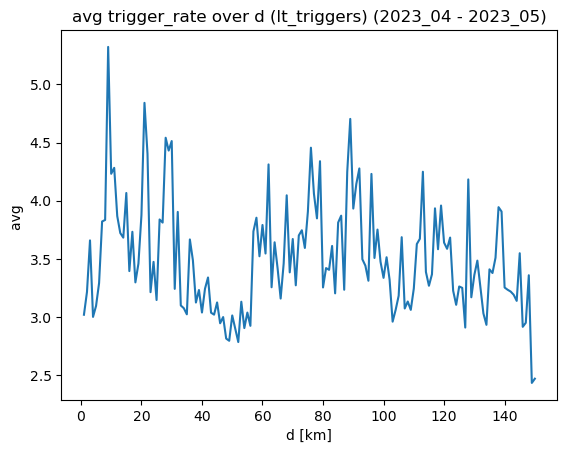

In [ ]:
test = sqldf('Select avg(sum_triggers_per_second) as avg_triggers_per_sec, round(d, 0) as d from result_df group by round(d, 0)')
plt.plot(test.d, test.avg_triggers_per_sec)
plt.title('avg trigger_rate over d (lt_triggers) (2023_04 - 2023_05)')
plt.xlabel('d [km]')
plt.ylabel('avg trigger rate')

Text(0, 0.5, '# triggers [Hz]')

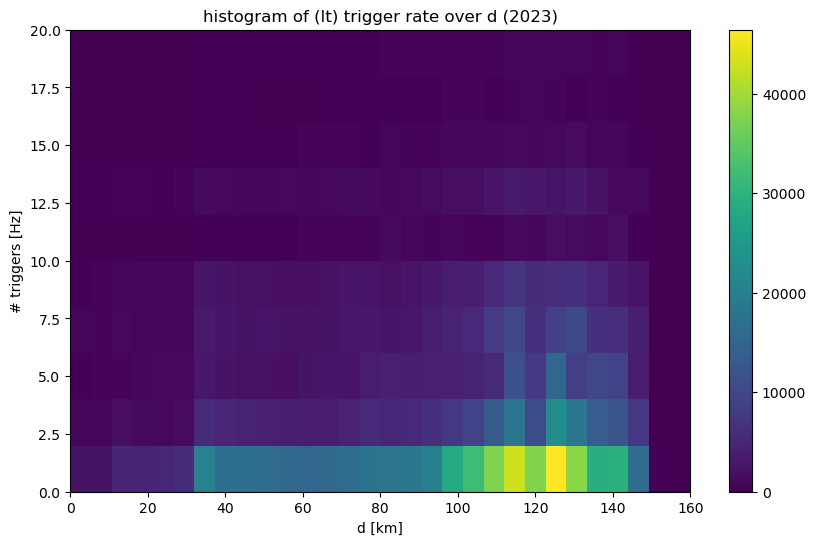

In [ ]:
from matplotlib.colors import LogNorm
#result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
#max_index = result_df['triggers_per_second'].idxmax()

plt.figure(figsize=(10, 6))
# Get the flightnumber at this index
#max_flightnumber = result_df.at[max_index, 'flightnumber']
#print(max_flightnumber)
#h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0, 15]], bins = [100, 10])
h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.sum_triggers_per_second, range = [[0, 160], [0,20]], bins = [30, 10])#, range = [[0, 160], [0, 15]], bins = [100, 15])#, norm = LogNorm())
plt.colorbar()
#plt.semilogy()
plt.title('histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_2023.pdf')

Text(0, 0.5, '# counts')

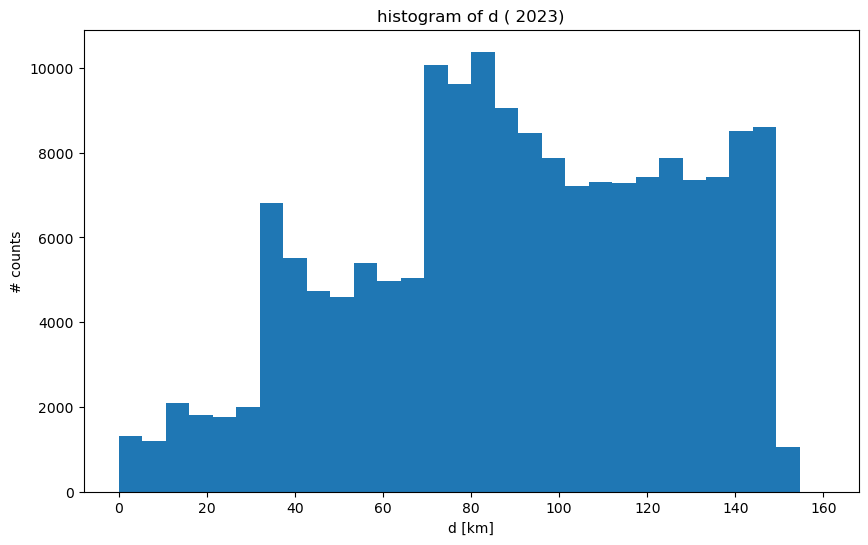

In [ ]:
plt.figure(figsize=(10, 6))
a = plt.hist(np.sqrt(flights.r2), bins = xedges)

plt.title('histogram of d ( 2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# counts')
#plt.savefig('./saved_figures/hist_d_2023.pdf')

/tmp/ipykernel_9226/2947665761.py:2: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(xedges, yedges, h.T/a[0])


Text(0, 0.5, '# triggers [Hz]')

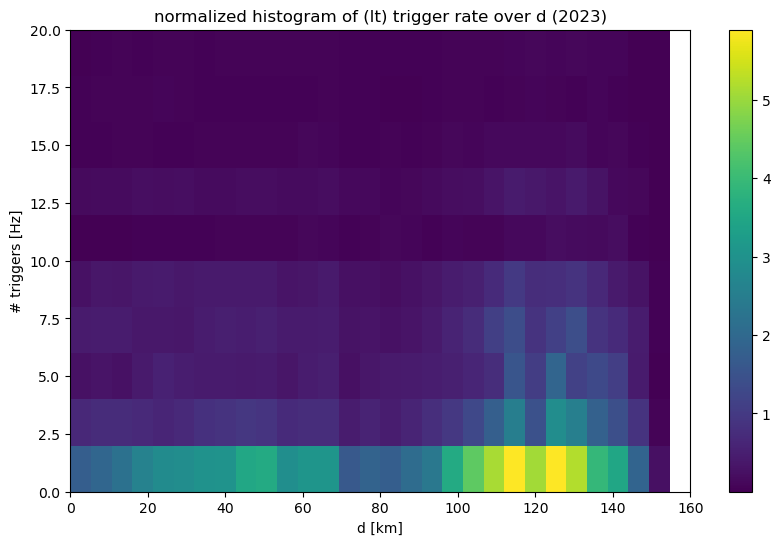

In [ ]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, h.T/a[0])
plt.colorbar()
plt.title('normalized histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_NORMALIZED_2023_0.pdf')

In [7]:
pd.options.display.float_format = '{:20,.2f}'.format

In [7]:
temp_df.trigger_time_millis

0          1682928357386
1          1682928369010
2          1682928369503
3          1682928371716
4          1682928374912
               ...      
4856104    1685526800990
4856105    1685526801763
4856106    1685526802987
4856107    1685526803648
4856108    1685526803869
Name: trigger_time_millis, Length: 4856109, dtype: int64

In [9]:
flights_distinct.mintime_stamp

0      1682971758100
1      1682929487600
2      1682938024100
3      1682938787800
4      1682941053800
           ...      
603    1685511484700
604    1685526407300
605    1685512489600
606    1685515941400
607    1685526804200
Name: mintime_stamp, Length: 608, dtype: int64